In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, XGradCAM, EigenCAM, LayerCAM, HiResCAM, FullGrad, RandomCAM
# , AblationCAM
from methods.ablation_cam import AblationCAM
from methods.score_cam import ScoreCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [2]:
model = models.vgg16(pretrained=True)
model.eval()
model = model.to('mps')

/Users/trungmai-eh/.pyenv/versions/3.10.14/envs/thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/trungmai-eh/.pyenv/versions/3.10.14/envs/thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
def input_link(name):
    img = Image.open(name).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img)
    return img_tensor.unsqueeze(0)

In [4]:
def predict_decode(yhat):
    probabilities = torch.softmax(yhat, dim=1)
    top5_prob_indices = torch.topk(probabilities, 5)[1].squeeze(0).tolist()

    with open("../labels.txt") as f:
        labels = [line.strip() for line in f.readlines()]

    top5_labels = [(labels[i], probabilities[0, i].item()) for i in top5_prob_indices]
    for i in top5_labels:
        print(i)
    return (top5_labels[0], int(yhat.argmax()))

In [5]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return x

In [6]:
def generate_flat_model(model=model):
    new_model = torch.nn.Sequential(*(list(model.children())[0] + torch.nn.Sequential(model.avgpool) + torch.nn.Sequential(Flatten()) + list(model.children())[2]))
    layers = torch.nn.Sequential(*(list(new_model.children())))
    return layers

In [7]:
def show_cam_on_image(
    img: np.ndarray, mask: np.ndarray, use_rgb: bool = False,
    colormap: int = cv2.COLORMAP_JET, image_weight: float = 0.005) -> np.ndarray:
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    cam = (1 - image_weight) * heatmap + image_weight * img
    cam = cam / np.max(cam)
    return np.uint16(255 * cam)
    # return np.uint16(255 * heatmap)

In [21]:
def cam_func(image, target_layers, cam_model):
    resized_img = cv2.resize(image, (224, 224))
    # Convert BGR to RGB (OpenCV loads images as BGR by default)
    image = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    cam = cam_model(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=image_tensor, targets=None)
    print("test", cam.upsample.shape)
    fig, axs = plt.subplots(4, 5, figsize=(10, 5))
    for i in range(4):
        for j in range(5):
            a = cam.upsample.cpu().detach().numpy()
            axs[i, j].imshow(a[0][5*i+j])
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
    # model_outputs = cam.outputs
    # plt.imshow(visualization)
    # plt.show()
    return visualization

def visualization(img):
    plt.imshow(img)
    plt.show()

In [9]:
file_path = 'example.txt'
results = []
def write(file_path, content):
    print(content)
    # Open the file in write mode ('w')
    with open(file_path, "a") as f:
        # Write to the file
        f.write(f"{content}")
        f.write("\n")

('Bedlington terrier', 0.13756416738033295)
('standard schnauzer', 0.10601019114255905)
('bluetick', 0.06678615510463715)
('standard poodle', 0.05869981274008751)
('wire-haired fox terrier', 0.053386952728033066)


AttributeError: 'GradCAM' object has no attribute 'upsampled'

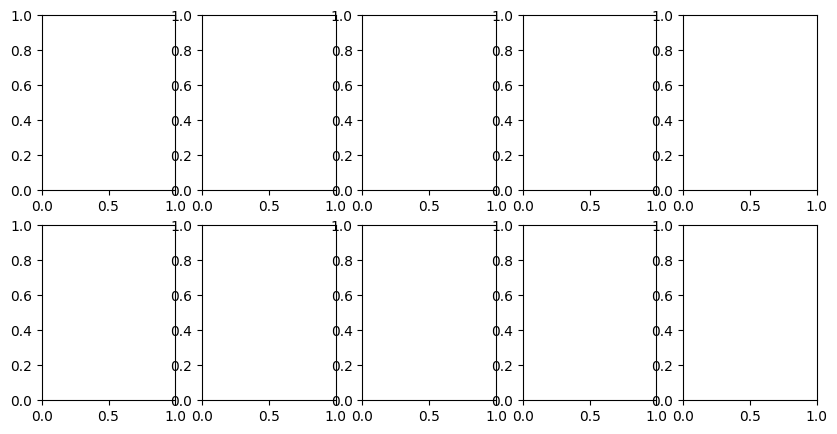

In [10]:
image_path = f"test.jpeg"
image_tensor = input_link(image_path)
image_tensor = image_tensor.to("mps")
yhat = model(image_tensor)
result = predict_decode(yhat)
results.append(result)
label = result[1]
target_layers = [model.features[-1]]
targets = [ClassifierOutputTarget(label)]
img = cv2.imread(image_path)
resized_img = cv2.resize(img, (224, 224))
img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
fig, axs = plt.subplots(2, 5, figsize=(10, 5))

model_CAM = [GradCAM, ScoreCAM, GradCAMPlusPlus, XGradCAM, EigenCAM, LayerCAM, AblationCAM, HiResCAM, FullGrad, RandomCAM]
# Load and display each image
for i in range(2):
    for j in range(5):
        image = cam_func(img, target_layers, model_CAM[5*i+j])
        axs[i, j].imshow(image)
        axs[i, j].set_title(f"{model_CAM[5*i+j].__name__}", fontsize=10)
        axs[i, j].axis('off')  # Hide axes


# Show the plot (optional)
plt.show()

upsampled: torch.Size([1, 512, 224, 224])
test torch.Size([1, 512, 224, 224])


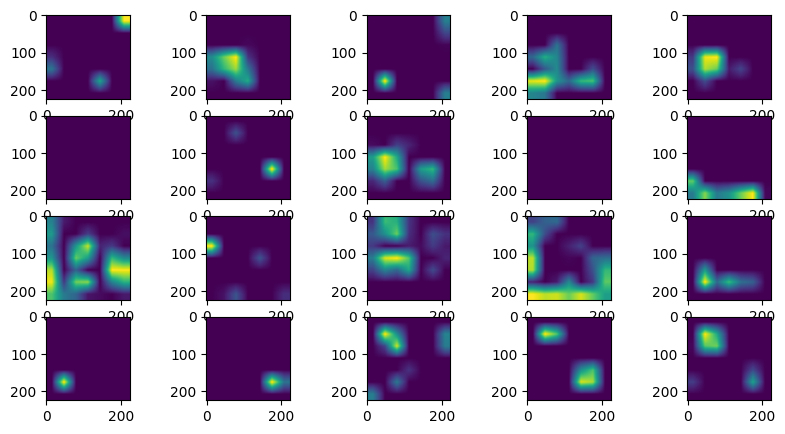

In [23]:
image = cam_func(img, target_layers, ScoreCAM)
# plt.imshow(image)

In [ ]:
write(file_path, results)

[(('orange', 0.4100935161113739), 950), (('drake', 0.9999995231628418), 97), (('shovel', 0.9920927882194519), 792)]


In [14]:
# yhat = model(image_tensor)
# result = predict_decode(yhat)

In [15]:
# label = result[1]
# label

In [16]:
# # Load the image
# img = cv2.imread(image_path)
# resized_img = cv2.resize(img, (224, 224))
# # Convert BGR to RGB (OpenCV loads images as BGR by default)
# img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

In [17]:
# target_layers = [model.features[-1]]
# targets = [ClassifierOutputTarget(label)]

In [18]:
# plt.imshow(img)
# plt.axis('off')  # Hide axes
# plt.show()

In [19]:
# image = cam_func(img, target_layers, ScoreCAM)
# visualization(image)

In [20]:
# # Create a 2x4 grid for 8 images
# fig, axs = plt.subplots(2, 3, figsize=(10, 5))

# model_CAM = [GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM]
# # Load and display each image
# for i in range(2):
#     for j in range(3):
#         # Load the image (replace this with your image loading code)
#         print(model_CAM[3*i+j])
#         image = cam_func(img, target_layers, model_CAM[3*i+j])
#         # Display the image
#         axs[i, j].imshow(image)
#         axs[i, j].set_title(f"{model_CAM[3*i+j].__name__}", fontsize=10)
#         axs[i, j].axis('off')  # Hide axes

# plt.show()

In [21]:
# # Create a 2x4 grid for 8 images
# fig, axs = plt.subplots(1, 7, figsize=(10, 5))

# axs[0].imshow(img)
# axs[0].set_title(f"Truth", fontsize=10)
# axs[0].axis('off')  # Hide axes

# model_CAM = [GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM]
# # Load and display each image
# for i in range(len(model_CAM)):
#     # Load the image (replace this with your image loading code)
#     print(model_CAM[i])
#     image = cam_func(img, target_layers, model_CAM[i])
#     # Display the image
#     axs[i+1].imshow(image)
#     axs[i+1].set_title(f"{model_CAM[i].__name__}", fontsize=10)
#     axs[i+1].axis('off')  # Hide axes

# plt.show()